In [1]:
# !pip install torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html

In [1]:
import torch
torch.cuda.is_available()

True

In [17]:
# !mkdir data2
# !apt-get update
# !apt-get install wget
# ! wget https://voice-prod-bundler-ee1969a6ce8178826482b88e843c335139bd3fb4.s3.amazonaws.com/cv-corpus-4-2019-12-10/es.tar.gz -P data2
# !rm data2/*.tar.gz*

In [18]:
# !tar -C data2/ -zxvf data2/es.tar.gz

In [19]:
# !du -sh data2/clips/

In [2]:
get_ipython().run_line_magic('matplotlib', 'inline')
# get_ipython().system('pip install snakeviz')
get_ipython().run_line_magic('load_ext', 'snakeviz')

In [3]:
# get_ipython().system('pip install git+https://github.com/mogwai/fastai_audio@0.1')

In [4]:
# !sudo apt update
# !sudo apt-get install libsndfile1-dev -y
# !pip install numba==0.43.0
# !pip install sndfile
from audio import *

In [5]:
torch.cuda.is_available()
# torch.cuda.current_device()
# torch.cuda.set_device(0)

True

In [6]:
torch.cuda.current_device()
# torch.cuda.get_device_name(0)
torch.cuda.set_device(0)

In [7]:
sg_cfg= SpectrogramConfig(hop_length=80, n_mels=80, n_fft=480, top_db=80, f_min=20.0, f_max=16000)
config_split= AudioConfig(resample_to = 8000, remove_silence="all", silence_padding=200, silence_threshold=20, sg_cfg=sg_cfg, duration=5000, pad_mode='zeros-after')

In [8]:
train_df = pd.read_csv(Path("./data2/validated.tsv"),sep="\t")

In [9]:
class ImageAudioList(AudioList):
    _bunch = ImageDataBunch
    context = 11
    def reconstruct(self, x): return Image(torch.stack([i[:,self.context+1] for i in x],dim=1).unsqueeze(0))
    
    def show_xys(self, xs, ys)->None:
        items = [[x,y] for i, (x,y) in enumerate(zip(xs,ys))]
        for item in items:
            display(*item)

In [10]:
class SentenceCharList(ItemList):
    
    itoc = list("abcdefghijklmnopqrstuvwxyzáéíñóúü '")+['']
    ctoi = defaultdict(lambda: 35)
    def __init__(self, items, path, **kwargs):
        super().__init__(items, **kwargs)
        for i,char in enumerate(self.itoc):
            self.ctoi[char]=i
        
    def get(self,i):
        return F.pad(torch.tensor([self.ctoi[j] for j in self.items[i].lower()]), pad=(0,200), mode='constant', value=35)[:100]

    def reconstruct(self, t:Tensor):
        return "".join((self.itoc[c] for c in t[0]))

In [11]:

#My solution to having to look through training files to make sure they are in training and not validation. 
train_file = defaultdict(bool)
for i in train_df.path:
    train_file[i] = True

In [12]:
def _slice_context(b, context):
    x,y = b
    input_lengths = []
    for input_line in x.sum(dim=2).flip(2,):
        count=0
        total_length = input_line[0].shape[0]
        for elem in input_line[0]:
            if elem != 0.0000:
                break;
            count+=1
        input_lengths.append(total_length-count)
    input_lengths = torch.tensor(input_lengths)
    x = F.pad(x, pad=(context,context))
    x = torch.stack([x[:,:,:,i:i+(context*2+1)] for i in range(x.shape[-1]-(context*2))],dim=2).squeeze()
    return x,(y,input_lengths)

In [13]:
# get_ipython().system('conda activate pytorch-conda -y')
# get_ipython().system('conda install -c conda-forge sox -y ')
# get_ipython().system('conda install -c pytorch torchaudio -y')
# get_ipython().system('python -c "import torchaudio"')

In [15]:
data = (ImageAudioList.from_folder("data2/clips", config=config_split)
#        .use_partial_data(0.05, seed=42)
        .filter_by_func(lambda x: train_file[x.name])
        .split_by_rand_pct(0.05, seed=42)
        .label_from_func(lambda x: train_df[train_df.path==str(x).split("/")[-1]]["sentence"].iloc[0], label_cls=SentenceCharList)
        .databunch(bs=32)
        .normalize()
       )

Filtered out 2 empty files
Preprocessing: Resampling to 8000


Preprocessing: Removing Silence


Preprocessing: Resampling to 8000


Preprocessing: Removing Silence


In [16]:
data.add_tfm(partial(_slice_context, context=11))


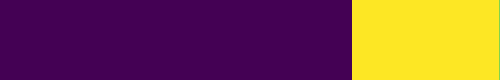

'la donada murmuró con tímida curiosidad'

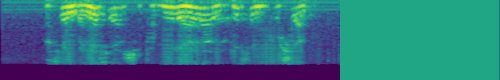

'nacido en venecia su familia era de origen prusiano'

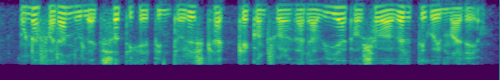

'una farándula exótica y pintoresca que con su algarabía causaba vértigo y mareo'

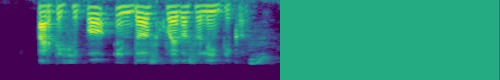

'participó en dos juegos olimpicos'

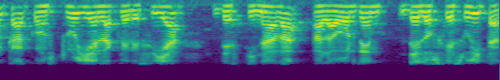

'en salamanca construye la clerecía destinada a la orden de los jesuitas'

In [17]:
data.show_batch()


In [ ]:
class DeepSpeech(nn.Module):
    def __init__(self, context=5, bs=64):
        super(DeepSpeech, self).__init__()
        self.bs = bs
        self.context = context
        self.flatten = nn.Flatten()#lambda x: torch.reshape(x,(-1,1,2432))
        self.h1 = nn.Linear(80*2*self.context+80,2048)
        self.h2 = nn.Linear(2048,2048)
        self.h3 = nn.Linear(2048,2048)
        #self.h4 = nn.LSTM(2048,2048,bidirectional=True,batch_first=True)
        self.h4 = nn.RNN(2048,2048, nonlinearity="relu",bidirectional=True)
        self.h5 = nn.Linear(2048,36) #ct ∈ {a,b,c, . . . , z, space, apostrophe, blank}
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, x):
        x = x.view(x.shape[0],-1,80*2*self.context+80)
        x = self.h1(x).clamp(min=0, max=20)
        x = self.h2(x).clamp(min=0, max=20)
        x = self.h3(x).clamp(min=0, max=20)
        x,h = self.h4(x)
        x = x.view(-1,500,2,2048)
        x = x.sum(dim=2)
        x = self.h5(x).clamp(min=0, max=20)
        x = self.softmax(x)
        x = x.permute(1,0,2)
        return x

In [19]:
# def ctc_loss(input, target, bs=64, blank=28):
#     r"""Loss function that makes CTC Loss easier to use especially for putting into a fastai Learner"""
#     i_length = torch.tensor([sum([1 for i in t.sum(1) if i != 0]) for t in input])
#     input = input.permute(1,0,2).detach().requires_grad_()
#     ctc = nn.CTCLoss(blank=blank, zero_infinity=True, reduction="sum")
#     t_length = torch.tensor([sum([1 for i in t if i != blank])for t in target])
#     ret = ctc(input, target, input_lengths=i_length, target_lengths=t_length)#torch.tensor([100]*input.size(1)))
#     return ret

In [20]:
def calculate_sizes(x):
    return x.shape[0] - (x.argmax(dim=2)==35).sum(axis=0)
#     input_lengths = []
#     for input_line in x.argmax(dim=2).flip(1,)==x.argmax(dim=2).flip(1,)[:,0][:,None]:
#         count=0
#         total_length = input_line.shape[0]
#         for elem in input_line:
#             if not elem:
#                 break;
#             count+=1
#         input_lengths.append(total_length-count)
    
#     return torch.tensor(input_lengths)

In [21]:
def ctc_loss(log_loss, target, i_length, bs=64, blank=35):
    r"""Loss function that makes CTC Loss easier to use especially for putting into a fastai Learner"""
    #i_length = torch.tensor([sum([1 for i in t.sum(1) if i != 0]) for t in input])
    i_length = i_length.long()
    ctc = nn.CTCLoss(blank=blank, zero_infinity=True, reduction="sum")
    t_length = target.shape[-1]-(target==35).sum(dim=1).long()
    target = target.long()
    #t_length = torch.tensor([sum([1 for i in t if i != blank])for t in target])
    ret = ctc(log_loss, target, input_lengths=i_length, target_lengths=t_length)
    #ret = F.ctc_loss(log_loss, target, input_lengths=i_length, target_lengths=t_length, blank=blank, reduction="sum", zero_infinity=True)
    return ret

In [22]:
model = DeepSpeech(context=data.x.context, bs=data.batch_size)


In [23]:
apply_init(model, nn.init.kaiming_normal_)


In [24]:
learn = Learner(data, model, loss_func=partial(ctc_loss,bs=data.batch_size))


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


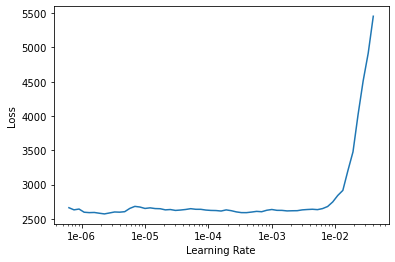

In [31]:
learn.lr_find()
learn.recorder.plot()


In [37]:
learn.fit_one_cycle(2,1e-3)


epoch,train_loss,valid_loss,time
0,2580.540527,2606.494141,1:08:02
1,2269.834961,2317.744629,1:07:53


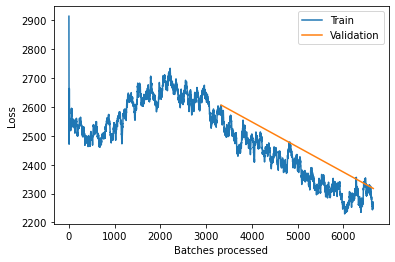

In [38]:
learn.recorder.plot_losses()


In [39]:
learn.save("fullDatasetStage1", return_path=True)

PosixPath('data2/clips/models/fullDatasetStage1.pth')

In [40]:
learn.export('fullDataSetStage1.pkl')

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


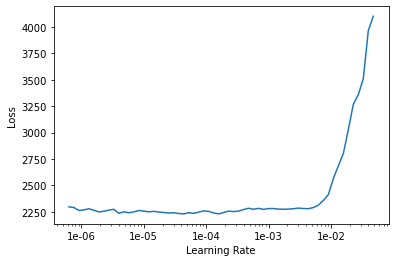

In [41]:
learn.lr_find();learn.recorder.plot()


In [62]:
learn.fit_one_cycle(3,1e-3)


epoch,train_loss,valid_loss,time


KeyboardInterrupt: 

In [ ]:
learn.save("fullDataSetStage2", return_path=True)


In [ ]:
learn.export('FullDataSettrained_model.pkl')

In [63]:
inp,targs = next(iter(learn.data.valid_dl))


In [64]:
preds = learn.model(inp)


In [65]:
def ctc_decoder(sequence, eps):
    #Step 1: merge equal stuff
    sequence = sequence.cpu().numpy()
    out = [sequence[0]]
    for item in sequence:
        if item != out[-1]: out.append(item)        
    #Step 2: remove all of the special token (eps)
    out = [p for p in out if p!=eps]
    return out

In [66]:
for phrase in range(32):
    print("".join([learn.data.itoc[i] for i in ctc_decoder(preds.argmax(dim=2)[:,phrase], 28)]))
    print("".join([learn.data.itoc[i] for i in targs[0][phrase]]))

s y ozoa ncoyr
aquellos mercenarios no la oyeron
 lociento locient
lo siento lo siento
pueadepiaente ecueaetos
fueron rápidamente depuestos
urar e a postodicotesenramo
uriarte apostólico de san ramón
ila porrnmebas erpana
 mira por dónde vas perdona
estamo dioensoseico pan caltuiermomento
estamos vivos eso significa que en cualquier momento 
ueno úue deniguno colgando po la cubierta
que no quede ninguno colgando por la cubierta
a curado variosiciviciones peci y sotogracio por egondo
ha curado varias exhibiciones de film y fotografía por el mundo

tal programa rogomatic fue desarrollado para jugar y ganar el juego
estoee cuerdoputile
esto me recuerda a un puzle
úueen uesunamosocapitande vandida
creo que es un famoso capitán de bandidos
bodaon pomo par pe renacmentimudanaameoputeare
gordon formó parte del renacimiento moderno de la lengua y cultura hebrea
vivlero carcingotanico plan de lan nagun
vivero jardín botánico plan de la laguna
laihade liretorcon e corazan d etahano acabosiciando